# MELODIST example

In this notebook the usage of MELODIST is demonstrated.
For this purpose, we use the station data for Rosenthal-Willershausen, which is located in the file `examples/testdata.csv.gz`.

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import melodist
import numpy as np
import pandas as pd
import scipy.stats

%matplotlib inline 

In [15]:
def plot(obs, sim):
    plt.figure()
    ax = plt.gca()
    obs.loc[plot_period].plot(ax=ax, color='black', label='obs', lw=2)
    sim.loc[plot_period].plot(ax=ax)
    plt.legend()
    plt.show()

def calc_stats(obs, sim):
    df = pd.DataFrame(columns=['mean', 'std', 'r', 'rmse', 'nse'])

    obs = obs.loc[validation_period]
    sim = sim.loc[validation_period]
    
    df.loc['obs'] = obs.mean(), obs.std(), 1, 0, 1
    
    for c in sim.columns:
        osdf = pd.DataFrame(data=dict(obs=obs, sim=sim[c])).dropna(how='any')
        o = osdf.obs
        s = osdf.sim
    
        r = scipy.stats.pearsonr(o, s)[0]
        rmse = np.mean((o - s)**2)
        nse = 1 - np.sum((o - s)**2) / np.sum((o - o.mean())**2)
        df.loc[c] = s.mean(), s.std(), r, rmse, nse
    
    return df

def print_stats(obs, sim):
    df = calc_stats(obs, sim)
    html = df.round(2).style
    return html

First, we define the station data location, the station coordinates and time zone, and the periods for calibration, validation and plotting:

In [16]:
path_inp = 'testdata.csv.gz'
longitude = 8.86
latitude = 51.00
timezone = 1

calibration_period = slice('2014-01-01', '2015-12-31')
validation_period = slice('2016-01-01', '2016-12-31')
plot_period = slice('2016-09-03', '2016-09-05')

Then, we read in the hourly station data, convert the temperature values from °C to K, and truncate the data frame in order to obtain full days:

In [17]:
data_obs_hourly = pd.read_csv(path_inp, index_col=0, parse_dates=True)
data_obs_hourly.temp += 273.15
data_obs_hourly = melodist.util.drop_incomplete_days(data_obs_hourly)

In this example, we do not use actual observed daily data but aggregate the hourly values to daily data using the `daily_from_hourly` method:

In [18]:
data_obs_daily = melodist.util.daily_from_hourly(data_obs_hourly)

Next, we create a `Station` object:

In [19]:
station = melodist.Station(
    lon=longitude,
    lat=latitude,
    timezone=timezone,
    data_daily=data_obs_daily,
)

If hourly observations are available, they can be used to derive various statistics used in the disaggregation methods. For this purpose, we create a `StationStatistics` object and fill it with the hourly values (in this case only a subset thereof, as we want separate calibration and validation periods). Afterwards, the statistics for the individual variables are calculated.

In [20]:
station.statistics = melodist.StationStatistics(data_obs_hourly.loc[calibration_period])

stats = station.statistics
stats.calc_wind_stats()
stats.calc_humidity_stats()
stats.calc_temperature_stats()
stats.calc_radiation_stats()
stats.calc_precipitation_stats()

# Disaggregation

Now we are ready to perform the disaggregation of the daily values. In the examples below, we use different methods for the disaggregation of each of the individual variables, plot the results for a short period (specified with `plot_period` above) and calculate several statistics for the validation period.

## Temperature

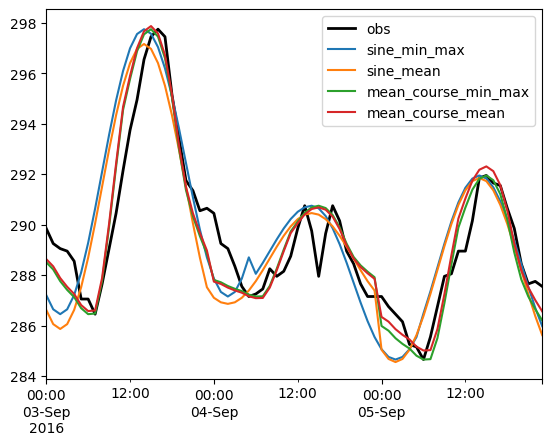

,mean,std,r,rmse,nse
obs,281.970000,7.450000,1.000000,0.000000,1.000000
sine_min_max,282.120000,7.600000,0.980000,2.280000,0.960000
sine_mean,281.980000,7.500000,0.980000,2.120000,0.960000
mean_course_min_max,281.800000,7.730000,0.980000,1.850000,0.970000
mean_course_mean,281.980000,7.480000,0.990000,1.470000,0.970000


In [21]:
tempdf = pd.DataFrame()
for method in ('sine_min_max', 'sine_mean', 'mean_course_min_max', 'mean_course_mean'):
    station.disaggregate_temperature(method=method, min_max_time='sun_loc_shift')
    tempdf[method] = station.data_disagg.temp

plot(data_obs_hourly.temp, tempdf)
print_stats(data_obs_hourly.temp, tempdf)

## Humidity

For some of the humidity disaggregation methods already disaggregated temperature values need to be available. Hence, we first run the temperature disaggregation again (in this case assuming we have decided for the `'sine_min_max'` method) and then perform the humidity disaggregation.

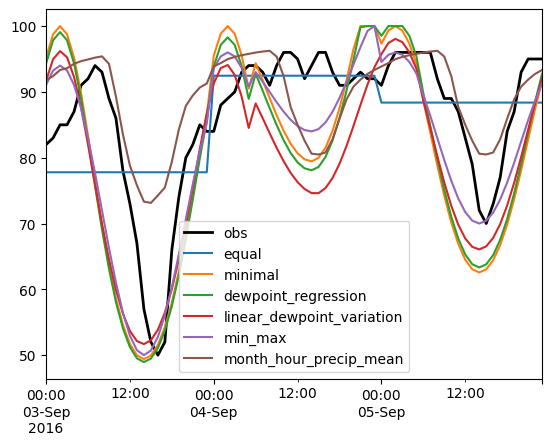

,mean,std,r,rmse,nse
obs,86.600000,13.400000,1.000000,0.000000,1.000000
equal,86.600000,9.500000,0.710000,89.460000,0.500000
minimal,80.720000,16.010000,0.690000,175.100000,0.030000
dewpoint_regression,85.760000,15.980000,0.740000,117.820000,0.340000
linear_dewpoint_variation,86.130000,14.990000,0.750000,103.290000,0.420000
min_max,84.130000,14.170000,0.890000,47.690000,0.730000
month_hour_precip_mean,86.080000,10.320000,0.760000,75.920000,0.580000


In [22]:
# ok, let's say we have decided to use sine_min_max. next we want to disaggregate humidity.
# as some of hum disagg functions rely on disagg'd temperature values we disagg temp again
# with our chosen method
station.disaggregate_temperature(method='sine_min_max', min_max_time='sun_loc_shift')

humdf = pd.DataFrame()
for method in (
    'equal',
    'minimal',
    'dewpoint_regression',
    'linear_dewpoint_variation',
    'min_max',
    'month_hour_precip_mean',
):
    station.disaggregate_humidity(method=method)
    humdf[method] = station.data_disagg.hum

plot(data_obs_hourly.hum, humdf)
print_stats(data_obs_hourly.hum, humdf)

Here, `'min_max'` yields the best results, however minimum and maximum daily humidity values are rarely available in practice. If mean daily humidity is available, setting `preserve_daily_mean=True` further improves the results (of all methods).

## Radiation

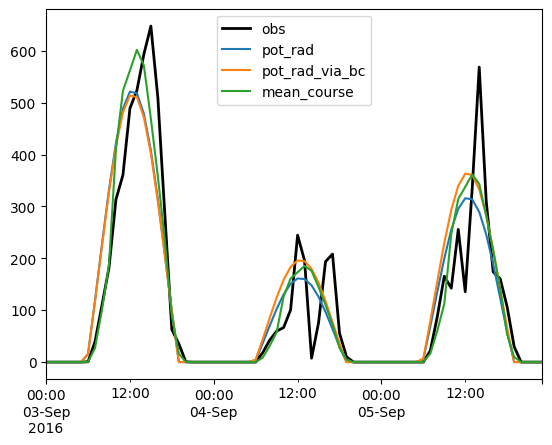

,mean,std,r,rmse,nse
obs,114.070000,196.420000,1.000000,0.000000,1.000000
pot_rad,114.340000,178.860000,0.950000,4125.610000,0.890000
pot_rad_via_bc,101.260000,156.970000,0.910000,7315.060000,0.810000
mean_course,114.340000,186.000000,0.960000,3257.960000,0.920000


In [23]:
globdf = pd.DataFrame()
for method in (
    'pot_rad',
    # 'pot_rad_via_ssd',  # not possible here as we do not have sunshine duration data
    'pot_rad_via_bc',
    'mean_course',
):
    station.disaggregate_radiation(method=method)
    globdf[method] = station.data_disagg.glob

plot(data_obs_hourly.glob, globdf)
print_stats(data_obs_hourly.glob, globdf)

## Wind speed

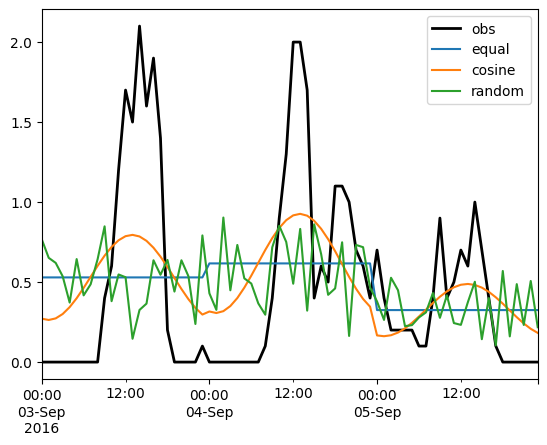

,mean,std,r,rmse,nse
obs,0.730000,0.800000,1.000000,0.000000,1.000000
equal,0.730000,0.530000,0.660000,0.360000,0.440000
cosine,0.730000,0.620000,0.760000,0.260000,0.580000
random,0.660000,0.540000,0.580000,0.440000,0.310000


In [24]:
winddf = pd.DataFrame()
for method in ('equal', 'cosine', 'random'):
    station.disaggregate_wind(method=method)
    winddf[method] = station.data_disagg.wind

plot(data_obs_hourly.wind, winddf)
print_stats(data_obs_hourly.wind, winddf)

## Precipitation

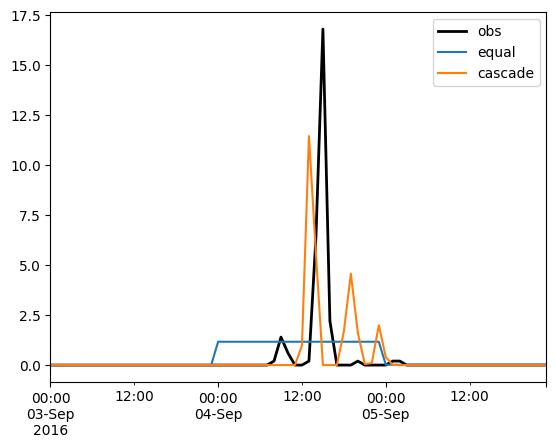

In [25]:
precipdf = pd.DataFrame()
for method in ('equal', 'cascade'):
    station.disaggregate_precipitation(method=method)
    precipdf[method] = station.data_disagg.precip
    
plot(data_obs_hourly.precip, precipdf)